## Face Recognition

Here we will take data from sklearn.datasets where we have total samples: 13233. we will take those samples in our datasets retain pictures of people that have at least 70.

In [111]:
import numpy as np
import pylab as pl
import logging
from time import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import RandomizedPCA, PCA
from sklearn.datasets import fetch_lfw_people

Load Data

In [112]:
lfw_people = fetch_lfw_people('data', min_faces_per_person=70, resize=0.4)


In [113]:
print(lfw_people.keys())

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])


In [114]:
lfw_people.images.shape

(1217, 50, 37)

In [115]:
lfw_people.data.shape #50*37=1850

(1217, 1850)

In [116]:
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

Here we have two keys which represent each pixel in our data one is 'images' where each pixel is at it exacy position as in original image (like a matrix). And another is 'data' where we have those pixels in a form of list. We use 'data' because reative pixel position can be ignored by this model.

In [117]:
lfw_people['images'][1]

array([[ 11.      ,  13.333333,  15.666667, ..., 197.33333 , 194.      ,
        197.66667 ],
       [ 12.666667,  14.      ,  17.666666, ..., 192.66667 , 186.66667 ,
        188.66667 ],
       [ 13.333333,  13.      ,  20.      , ..., 193.      , 190.66667 ,
        185.66667 ],
       ...,
       [ 64.333336,  68.666664,  64.      , ..., 115.      , 123.666664,
        126.666664],
       [ 61.666668,  63.333332,  64.      , ..., 119.666664, 124.666664,
        126.666664],
       [ 65.      ,  61.666668,  60.      , ..., 120.666664, 122.666664,
        132.      ]], dtype=float32)

In [118]:
lfw_people['data'][1]

array([ 11.      ,  13.333333,  15.666667, ..., 120.666664, 122.666664,
       132.      ], dtype=float32)

In [119]:
# Data in X variable
X=lfw_people.data

In [120]:
# so total features we have
n_features = X.shape[1]
print('Total features: ', n_features)

Total features:  1850


In [121]:
# label to predict the ID of perosn
y=lfw_people.target
# Target names has 6 names only
target_names=lfw_people.target_names
n_classes=target_names.shape[0]

print('Total Dataset size:')
print('n_smaples:', n_samples)
print('n_features:', n_features)
print('classes: ', n_classes)

Total Dataset size:
n_smaples: 1217
n_features: 1850
classes:  6


Split data into training and testing set and compute PCA

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
# n_components == min(n_samples, n_features)
n_components = 150

print('Extract top {0} eigenfaces from {1} faces '.format(n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, whiten = True, svd_solver='randomized')
pca=pca.fit(X_train)
print('time taken: ', time()-t0)

Extract top 150 eigenfaces from 973 faces 
time taken:  0.11703824996948242


In [124]:
len(pca.components_[2])

1850

In [125]:
pca.components_.shape

(150, 1850)

In [126]:
# projecting data on pronciple components
eigenfaces = pca.components_.reshape(n_components,h,w)

X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

Now we will use SVM on new pca training set and create a model

In [127]:
para_grid = {
    'C':[1e3, 5e3, 1e4,5e4, 1e5],
    'gamma':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid = para_grid)
clf.fit(X_train_pca, y_train)

print('best estimator')
print(clf.best_estimator_)

best estimator
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [134]:
# Predict the output
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.50      0.67         8
     Colin Powell       0.92      0.79      0.85        61
  Donald Rumsfeld       0.89      0.65      0.76        26
    George W Bush       0.79      0.98      0.87       103
Gerhard Schroeder       1.00      0.78      0.88        18
       Tony Blair       0.85      0.82      0.84        28

      avg / total       0.86      0.85      0.84       244



In [131]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[  4   0   2   2   0   0]
 [  0  48   0  12   0   1]
 [  0   1  17   6   0   2]
 [  0   2   0 101   0   0]
 [  0   0   0   3  14   1]
 [  0   1   0   4   0  23]]


In [132]:
len(y_test)

244

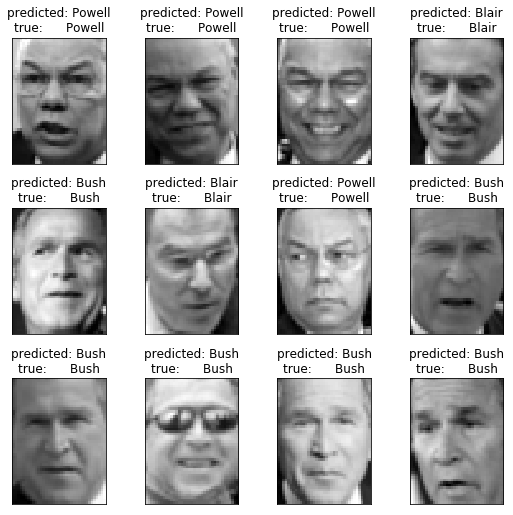

In [136]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())



# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return ('predicted: %s\ntrue:      %s' % (pred_name, true_name))

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

pl.show()

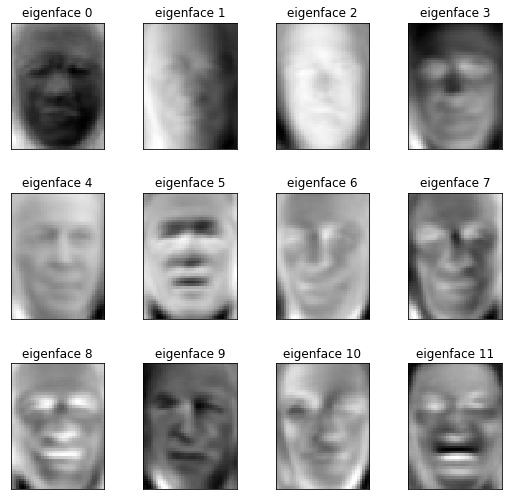

In [137]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

In [143]:
# Variance n each PC is explained by below list where it is keep on decresing from 1st onwards
print(pca.explained_variance_ratio_)

[0.17969728 0.1573181  0.07344005 0.06011249 0.05139661 0.03080087
 0.02524019 0.02169513 0.02064916 0.01939938 0.0164511  0.01441437
 0.01272006 0.01097792 0.01029883 0.01019455 0.00931264 0.00881183
 0.00818657 0.00740811 0.00704038 0.00668135 0.00649591 0.00595676
 0.00548895 0.00530443 0.00506916 0.00485467 0.0047413  0.00438598
 0.00395694 0.00384593 0.00371762 0.00362041 0.0035441  0.00340796
 0.0032079  0.00308308 0.00293944 0.00285323 0.00278705 0.00276857
 0.00263535 0.00255553 0.00247272 0.00244569 0.00237297 0.00228231
 0.00218246 0.00210346 0.00208801 0.00201008 0.00197199 0.00195628
 0.00184441 0.00183108 0.00177342 0.00176067 0.00172166 0.00166006
 0.00163324 0.00159565 0.00156543 0.00155763 0.00152139 0.00150788
 0.00148611 0.00145224 0.00141724 0.00138369 0.00134055 0.00133008
 0.00129012 0.00125066 0.00122227 0.00121562 0.00119882 0.00118402
 0.00116623 0.00114406 0.00112915 0.00110542 0.00109971 0.00108763
 0.00103617 0.00102537 0.00100821 0.00099901 0.00099538 0.0009